# Keras workflow Example


In [ ]:
# Reference: https://learnopencv.com/deep-learning-using-keras-the-basics/ 

# An example of image classification. Text is more complicated!

# 1. Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
 
# 2. Load pre-shuffled MNIST data into train and test sets
(X_train_image, y_train_image), (X_test_image, y_test_image) = mnist.load_data()
 
# 3. Preprocess input data
X_train_image = X_train_image.reshape(X_train_image.shape[0], 1, 28, 28)
X_test_image = X_test_image.reshape(X_test_image.shape[0], 1, 28, 28)
X_train_image = X_train_image.astype('float32')
X_test_image = X_test_image.astype('float32')
X_train_image /= 255
X_test_image /= 255
 
# 4. Preprocess class labels
Y_train_image = np_utils.to_categorical(y_train_image, 10)
Y_test_image = np_utils.to_categorical(y_test_image, 10)
 
# 5. Define model architecture
model = Sequential() 

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
 
# 6. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 7. Fit model on training data
model.fit(X_train_image, Y_train_image, batch_size=32, epochs=3, verbose=1)
 
# 8. Evaluate model on dev/test data
score = model.evaluate(X_test_image, Y_test_image, verbose=0)
print (score)

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6091 - accuracy: 0.8167
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2271 - accuracy: 0.9329
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1838 - accuracy: 0.9461
[0.10706740617752075, 0.9668999910354614]


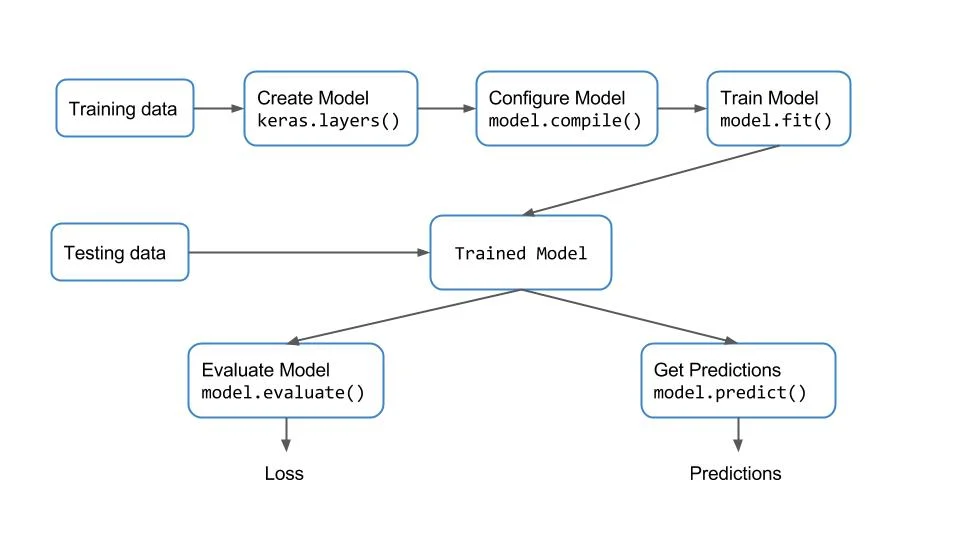

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Step 1: Load data

In [4]:
N_CLASSES = 4
path = '/content/drive/MyDrive/PY/NLP/'
train = pd.read_csv(path+'Tweets_train.csv')
dev = pd.read_csv(path+'Tweets_dev.csv')
test = pd.read_csv(path+'Tweets_test.csv')

## Step 1.1 Add your text preprocessing step

In [ ]:
# Add your preprocessing step, create a function called "preprocess"
# train['text'] = train['text'].apply(preprocess)
# dev['text'] = dev['text'].apply(preprocess)

In [5]:
train

,tweet_id,text,airline_sentiment
0,569179849518161920,@united you're good. Thank you!,positive
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",negative
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,positive
3,569525116725567491,@USAirways The automated message isn't helpful...,negative
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,positive
...,...,...,...
11853,570123872168574976,"@AmericanAir will not help us on the phone, at...",negative
11854,570063683256242177,@USAirways has the worst customer service line...,negative
11855,568032524749942784,@USAirways grades for this trip:\n\nFlight tim...,negative
11856,569705813142409217,@united Thanks for the vague canned response t...,negative


In [26]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokens = [word_tokenize(i) for i in train.text]
train["tokens"] =  tokens
dev["tokens"] =  [word_tokenize(i) for i in dev.text]
test["tokens"] =  [word_tokenize(i) for i in test.text]

In [21]:
le = LabelEncoder()
le.fit(train['airline_sentiment'])

LabelEncoder()

In [27]:
x_train = train['tokens']
y_train = le.transform(train['airline_sentiment'])
x_dev = dev['tokens']
y_dev = le.transform(dev['airline_sentiment'])
x_test = test['tokens']

In [28]:
x_train

0            [@, united, you, 're, good, ., Thank, you, !]
1        [@, AmericanAir, way, to, ruin, a, vacation, ,...
2        [@, JetBlue, yes, thankfully, !, Catering, jus...
3        [@, USAirways, The, automated, message, is, n'...
4        [@, JetBlue, I, 'm, #, MakingLoveOutofNothingA...
                               ...                        
11853    [@, AmericanAir, will, not, help, us, on, the,...
11854    [@, USAirways, has, the, worst, customer, serv...
11855    [@, USAirways, grades, for, this, trip, :, Fli...
11856    [@, united, Thanks, for, the, vague, canned, r...
11857    [@, united, already, did, that, at, the, airpo...
Name: tokens, Length: 11858, dtype: object

In [9]:
y_train

array([2, 0, 2, ..., 0, 0, 0])

# Step 2: Create a vocabulary index

In [33]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices([' '.join(i) for i in x_train]).batch(128)
vectorizer.adapt(text_ds)

You can retrieve the computed vocabulary used via `vectorizer.get_vocabulary()`. Let's
print the top 5 words:

In [34]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'to', 'i', 'the']

Let's vectorize a test sentence:

In [35]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([  4,   1, 580,  10,   4,   1])

As you can see, "the" gets represented as "2". Why not 0, given that "the" was the first
word in the vocabulary? That's because index 0 is reserved for padding and index 1 is
reserved for "out of vocabulary" tokens.

Here's a dict mapping words to their indices:

In [36]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

# Step 3: Load pre-trained word embeddings

Let's download pre-trained GloVe embeddings (a 822M zip file).

You'll need to run the following commands:

```
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
```

The archive contains text-encoded vectors of various sizes: 50-dimensional,
100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [ ]:
path_to_glove_file = "/content/drive/MyDrive/Colab Notebooks/Coursework/glove.6B/glove.6B.100d.txt"
print (path_to_glove_file)
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

/content/drive/MyDrive/Colab Notebooks/Coursework/glove.6B/glove.6B.100d.txt
Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras
`Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained
vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 15922 words (4078 misses)


Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to
update them during training).

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# Step 4: Build the models

Logistic regression

In [ ]:
from tensorflow.keras import layers
def build_regression():
    model= Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer'))
    
    model.compile(
                optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    #logReg.summary()
    return model

MLP

In [ ]:
def build_mlp(hidden_size=128):
    model= Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(hidden_size))
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer'))
    
    model.compile(
                optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

CNN

In [ ]:
# define your own classifiers here. For example: CNN, LSTM

We use categorical crossentropy as our loss since we're doing softmax classification.
Moreover, we use `sparse_categorical_crossentropy` since our labels are integers.

Define your own classifier here

### Step 4.1: Wrap the keras code to sklearn 

In [ ]:
NUM_EPOCHS = 1 # You can change the number of epochs

In [ ]:
reg = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_regression,
                            epochs=NUM_EPOCHS,
                            verbose=False)
reg._estimator_type = "classifier"

In [ ]:
mlp = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_mlp,
                            epochs=NUM_EPOCHS,
                            verbose=False)
mlp._estimator_type = "classifier"

In [ ]:
# add your own classifiers defined in keras

## Step 4.2: Model ensemble: combine different classification models, add your classifiers
reference https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier (Section 1.11.6. Voting Classifier)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
             estimators=[('mlp', mlp),
                         ('reg', reg) 
                         # Add more models here
                        ], 
             voting='soft',
             flatten_transform=True)

In [ ]:
x_train

0       From: sd345@city.ac.uk (Michael Collier)\nSubj...
1       From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...
2       From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...
3       From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...
4       From: stanly@grok11.columbiasc.ncr.com (stanly...
                              ...                        
1995    From: rcj2@cbnewsd.cb.att.com (ray.c.jender)\n...
1996    Organization: Penn State University\nFrom: And...
1997    From: seth@north1.acpub.duke.edu (Seth Wanders...
1998    From: reedr@cgsvax.claremont.edu\nSubject: Re:...
1999    From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...
Name: text, Length: 2000, dtype: object

# Step 5: Train the models 

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.

In [ ]:
# prepare training data
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_dev = vectorizer(np.array([[s] for s in x_dev])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array(y_train)
y_dev = np.array(y_dev)

In [ ]:
voting.fit(x_train, y_train) # training in sklearn 
reg.fit(x_train, y_train)

In [ ]:
mlp.fit(x_train, y_train) # training in sklearn 

In [ ]:
#cnn.fit(x_train, y_train)


In [ ]:
# training in Keras directly 
reg_keras=build_regression()
reg_keras.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_dev, y_dev))
# prediction
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = reg_keras(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["this message is about computer graphics and 3D modeling"]]
)

#class_names[np.argmax(probabilities[0])]

Epoch 1/5
16/16 [==============================] - 1s 27ms/step - loss: 3.7805 - accuracy: 0.3407 - val_loss: 1.8260 - val_accuracy: 0.5253
Epoch 2/5
16/16 [==============================] - 0s 6ms/step - loss: 0.8168 - accuracy: 0.7146 - val_loss: 1.5541 - val_accuracy: 0.5292
Epoch 3/5
16/16 [==============================] - 0s 6ms/step - loss: 0.4617 - accuracy: 0.8650 - val_loss: 0.5788 - val_accuracy: 0.7626
Epoch 4/5
16/16 [==============================] - 0s 6ms/step - loss: 0.3013 - accuracy: 0.9048 - val_loss: 0.8408 - val_accuracy: 0.6693
Epoch 5/5
16/16 [==============================] - 0s 6ms/step - loss: 0.1769 - accuracy: 0.9552 - val_loss: 1.1824 - val_accuracy: 0.7121


# Step 6: Evaluation

In [ ]:
y_dev_pred_mlp = mlp.predict(x_dev)
#y_dev_pred_cnn = mlp.predict(x_dev)
y_dev_pred_voting = voting.predict(x_dev)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Text(0.5, 1.0, 'F1 score for each model')

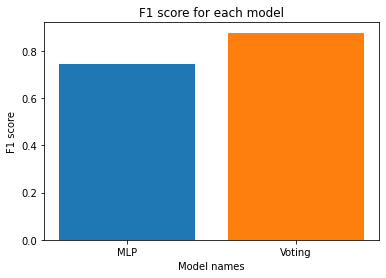

In [ ]:
plt.figure
f1_mlp = f1_score(y_dev, y_dev_pred_mlp, average='micro')
#f1_cnn = f1_score(y_dev, y_dev_pred_cnn, average='micro')
f1_voting = f1_score(y_dev, y_dev_pred_voting, average=None)

f1s = [f1_mlp,  f1_voting] #f1_cnn,
model_names = ['MLP',  'Voting'] # 'CNN',
for i in range(len(model_names)):
    f1 = f1s[i]
    model_name = model_names[i]
    plt.bar(model_name, f1)



plt.xlabel('Model names')
plt.ylabel('F1 score')
plt.title('F1 score for each model')

# Step 7:  Predict the dev/test set 

In [ ]:
y_pred = voting.predict(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
y_pred

array([2, 2, 0, ..., 2, 2, 1])

# Step 8:  Save the prediction to csv file

In [ ]:
pred_labels = le.inverse_transform(y_pred)
test['class'] = pred_labels
test.to_csv('/content/drive/MyDrive/Colab Notebooks/Coursework/20news/test_predicted.csv', index=False)

In [ ]:
test

,text,class
0,From: brian@ucsd.edu (Brian Kantor)\nSubject: ...,2
1,From: rind@enterprise.bih.harvard.edu (David R...,2
2,From: adwright@iastate.edu ()\nSubject: Re: ce...,0
3,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,0
4,From: jhpb@sarto.budd-lake.nj.us (Joseph H. Bu...,3
...,...,...
1497,From: andersom@spot.Colorado.EDU (Marc Anderso...,0
1498,From: bj368@cleveland.Freenet.Edu (Mike E. Rom...,0
1499,From: Donald Mackie <Donald_Mackie@med.umich.e...,2
1500,From: abruno@adobe (Andrea Bruno)\nSubject: Re...,2


In [ ]:
# References: Search: word embedding keras or text classification CNN
# scikit-learn  1.11.6. Voting Classifier https://scikit-learn.org/stable/modules/ensemble.html 
# Practical 4: https://keras.io/examples/nlp/pretrained_word_embeddings/ 
# https://www.kaggle.com/residentmario/using-keras-models-with-scikit-learn-pipelines
#

# Note: You can use any code. 

A. You can use different types of programming language code. 
For example, use java for pre-processing and save the pre-processed documents and then use python for training and prediction. You also can copy the results to excel to generate charts. 

B. Combined model means any of the following:
1) more than 1 pre-processing techniques + 1 classifier 
2) at least 1 pre-processing techniques + more than 1 classifier  

C. Select the best model. The prediction results matter. You can use either Accuracy or F1 as evaluation metrics in Task 2. 

D. First Class tips: use some advanced/recent models or create your own novel model (the model works well and the report is well-written).  

E. Put your referred paper, code, online tutorial in the references. Give in-text citation and follow the correct format. Describe your changes of code/method in your report if applicable. Write a ReadMe file about how to run your code.  

F. More reference papers and code: 

search: text classification or sentiment analysis in the website: paper with code https://paperswithcode.com/  Example paper: https://www.aclweb.org/anthology/S16-1027.pdf  

search: sentiment analysis github